In [77]:
from sklearn.metrics import roc_auc_score, roc_curve
from neptune.integrations.lightgbm import NeptuneCallback, create_booster_summary
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
import lightgbm as lgb
import numpy as np
import pandas as pd
import neptune


# Load Data
* Handle missing values, duplicated values, outlier

In [78]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/data/saved_data.csv")
total['Date'] = pd.to_datetime(total['Date'])

df = total.set_index('Date')
df.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-16,30310.3,30299.2,30545.3,30134.6,34.48,840992.0,4.788780e+13,1866594.290,495223185.0,484205.915377,...,2119.29,100.03,0.090465,0.52089,2015.6,25.438,9023.5,4137.64,33885.31,28493.47
2023-04-15,30299.6,30472.6,30586.5,30208.8,31.71,1045660.0,4.788780e+13,1839875.354,631025193.0,630623.285367,...,2090.59,96.66,0.088890,0.51930,2002.2,25.460,9023.5,4137.64,33885.31,28493.47
2023-04-14,30472.5,30387.4,30964.9,30026.0,98.38,1016042.0,4.788780e+13,1759535.436,559166432.0,858535.297189,...,2099.98,96.34,0.088707,0.52269,2002.2,25.460,9023.5,4137.64,33885.31,28493.47
2023-04-13,30387.4,29892.4,30524.1,29864.5,65.87,1009669.0,4.788780e+13,1812112.549,567094231.0,767012.808110,...,2012.11,94.19,0.087344,0.51244,2041.3,25.925,9058.5,4146.22,34030.34,28156.97
2023-04-12,29886.4,30209.8,30473.0,29679.5,78.69,1056542.0,4.788780e+13,1933495.919,635037442.0,757368.783682,...,1916.58,92.02,0.083398,0.50473,2010.9,25.458,8916.5,4091.95,33647.22,28082.70


In [79]:
df.shape

(4654, 23)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654 entries, 2023-04-16 to 2010-07-20
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BTC_close                   4654 non-null   float64
 1   BTC_open                    4654 non-null   float64
 2   BTC_high                    4654 non-null   float64
 3   BTC_low                     4654 non-null   float64
 4   BTC_volume                  4654 non-null   float64
 5   Active_Addr_Cnt             4654 non-null   float64
 6   Difficulty                  4654 non-null   float64
 7   Mean_Block_Size(in_bytes)   4654 non-null   float64
 8   Sum_Block_Weight            4654 non-null   float64
 9   Total_Fees(USD)             4654 non-null   float64
 10  Mean_Hashrate               4654 non-null   float64
 11  Xfer_Cnt                    4654 non-null   float64
 12  Mean_Tx_size(native_units)  4654 non-null   float64
 13  ETH            

In [81]:
df.describe()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
count,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,...,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,8950.828126,8944.396197,9182.648904,8680.543532,144.272183,4.974545e+05,7.399910e+12,6.883463e+05,3.329426e+08,5.498044e+05,...,505.010290,45.052975,0.026408,0.229873,1474.337129,21.657901,7112.199345,2492.349280,21487.496401,18751.425404
std,14517.759120,14515.100053,14900.138248,14078.916437,199.685947,3.731797e+05,1.103629e+13,4.990862e+05,2.151278e+08,1.528054e+06,...,945.449318,63.364718,0.069391,0.334681,253.778406,6.479395,1491.343889,989.044608,7511.506584,6322.971966
min,0.100000,0.100000,0.100000,0.000000,0.170000,4.080000e+02,1.820000e+02,4.164167e+02,2.841400e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1049.600000,11.772000,0.000000,1047.220000,9985.810000,8160.010000
25%,140.475000,140.400000,145.800000,135.825000,25.407500,8.702175e+04,1.322172e+08,1.656955e+05,1.124594e+08,3.741492e+03,...,0.000000,0.000000,0.000000,0.000000,1260.025000,16.624500,5947.125000,1697.435000,15464.300000,14313.030000
50%,916.050000,915.050000,934.150000,877.350000,63.605000,5.389900e+05,2.840750e+11,7.887917e+05,4.066180e+08,6.090908e+04,...,12.430000,3.870000,0.000000,0.008870,1371.850000,19.570000,6962.000000,2204.720000,19161.280000,19435.830000
75%,9932.450000,9926.450000,10231.950000,9636.050000,158.375000,8.174050e+05,1.389755e+13,1.087807e+06,5.072356e+08,4.321621e+05,...,396.107500,67.199500,0.003335,0.350712,1721.025000,25.340750,8151.437500,3046.155000,26828.202500,22902.512500
max,67527.900000,67528.700000,68990.600000,66334.900000,999.530000,1.366494e+06,4.788780e+13,2.535436e+06,7.584308e+08,2.139776e+07,...,4808.380000,386.820000,0.686880,2.780000,2069.400000,48.599000,10674.000000,4796.560000,36799.650000,30670.100000


<Axes: >

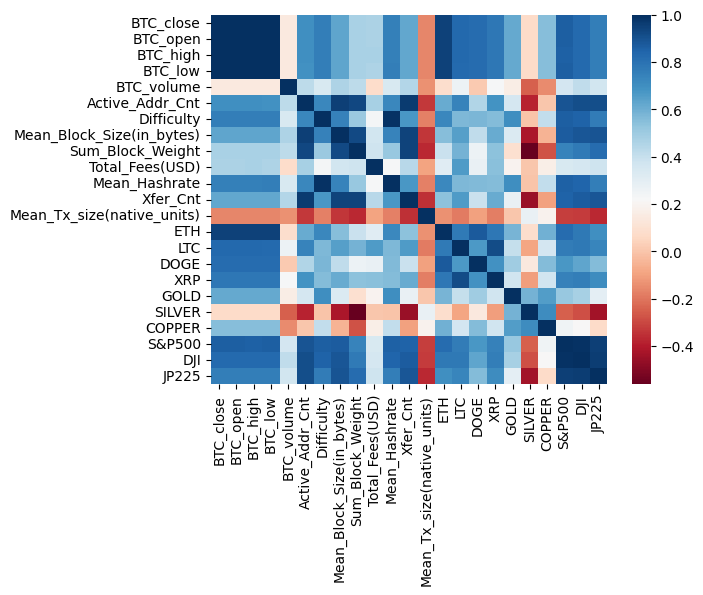

In [82]:
sns.heatmap(df.corr(), cmap="RdBu")

# Slpit Data (Testing, Training Data Sets)

In [83]:
from datetime import datetime

for index in total.index:
    total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y-%m-%d').date()

Start_day = date(2016, 3, 10)
Test_day = date(2021,11,1)
End_day = date(2023,4,16)


# train, test
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day)].reset_index(drop = True)
train_dataset = total[total["Date"] < Test_day].reset_index(drop = True)
test_dataset = total[total["Date"] >= Test_day].reset_index(drop = True)


In [84]:
X_train = train_dataset.drop(["Date"], axis=1)[:-1]
y_train = train_dataset["BTC_close"][1:].reset_index(drop=True)

X_test = test_dataset.drop(["Date"], axis=1)[:-1]
y_test = test_dataset["BTC_close"][1:].reset_index(drop=True)

In [85]:
test_ratio = len(test_dataset) / len(total)

print("Tỉ lệ test_data/total:", test_ratio)

Tỉ lệ test_data/total: 0.20508866615265997


In [86]:
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train: (2061, 23)
Kích thước y_train: (2061,)
Kích thước X_test: (531, 23)
Kích thước y_test: (531,)


# Load Model

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [88]:
model = lgb.LGBMRegressor()

### Default

In [89]:
model.fit(X_train, y_train)

LGBMRegressor()

In [90]:
predictions = model.predict(X_test)


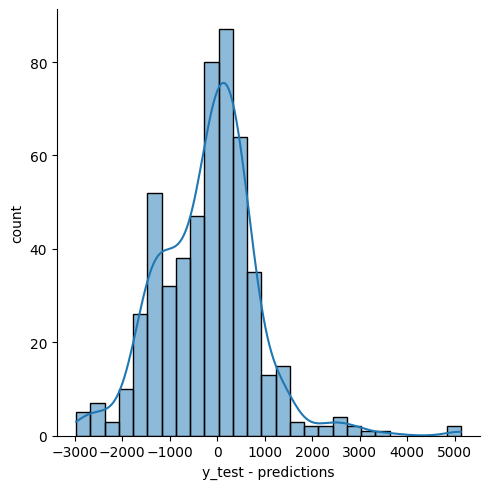

In [91]:

sns.displot(y_test - predictions, kde=True)
plt.xlabel('y_test - predictions')
plt.ylabel('count')
plt.show()

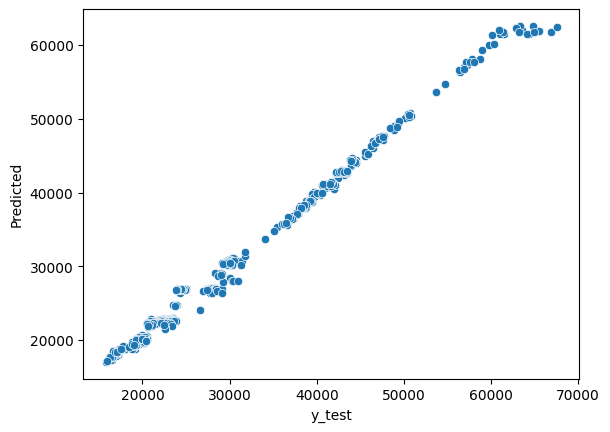

In [92]:
sns.scatterplot(x=y_test, y=predictions)
plt.xlabel('y_test')
plt.ylabel('Predicted')
plt.show()

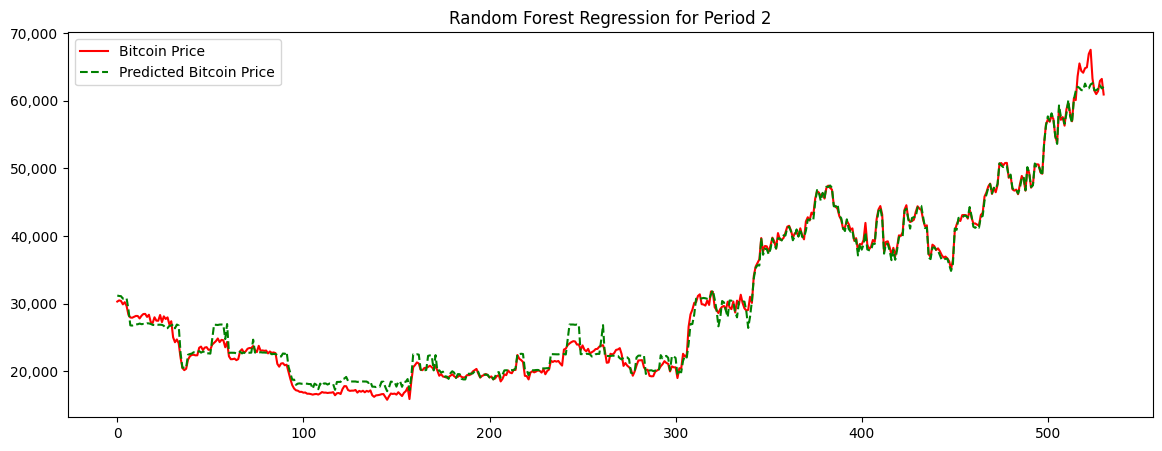

In [93]:

#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(y_test, color = 'red', label="Bitcoin Price")
ax.plot(predictions, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 2")
plt.legend()
plt.show()

<Axes: >

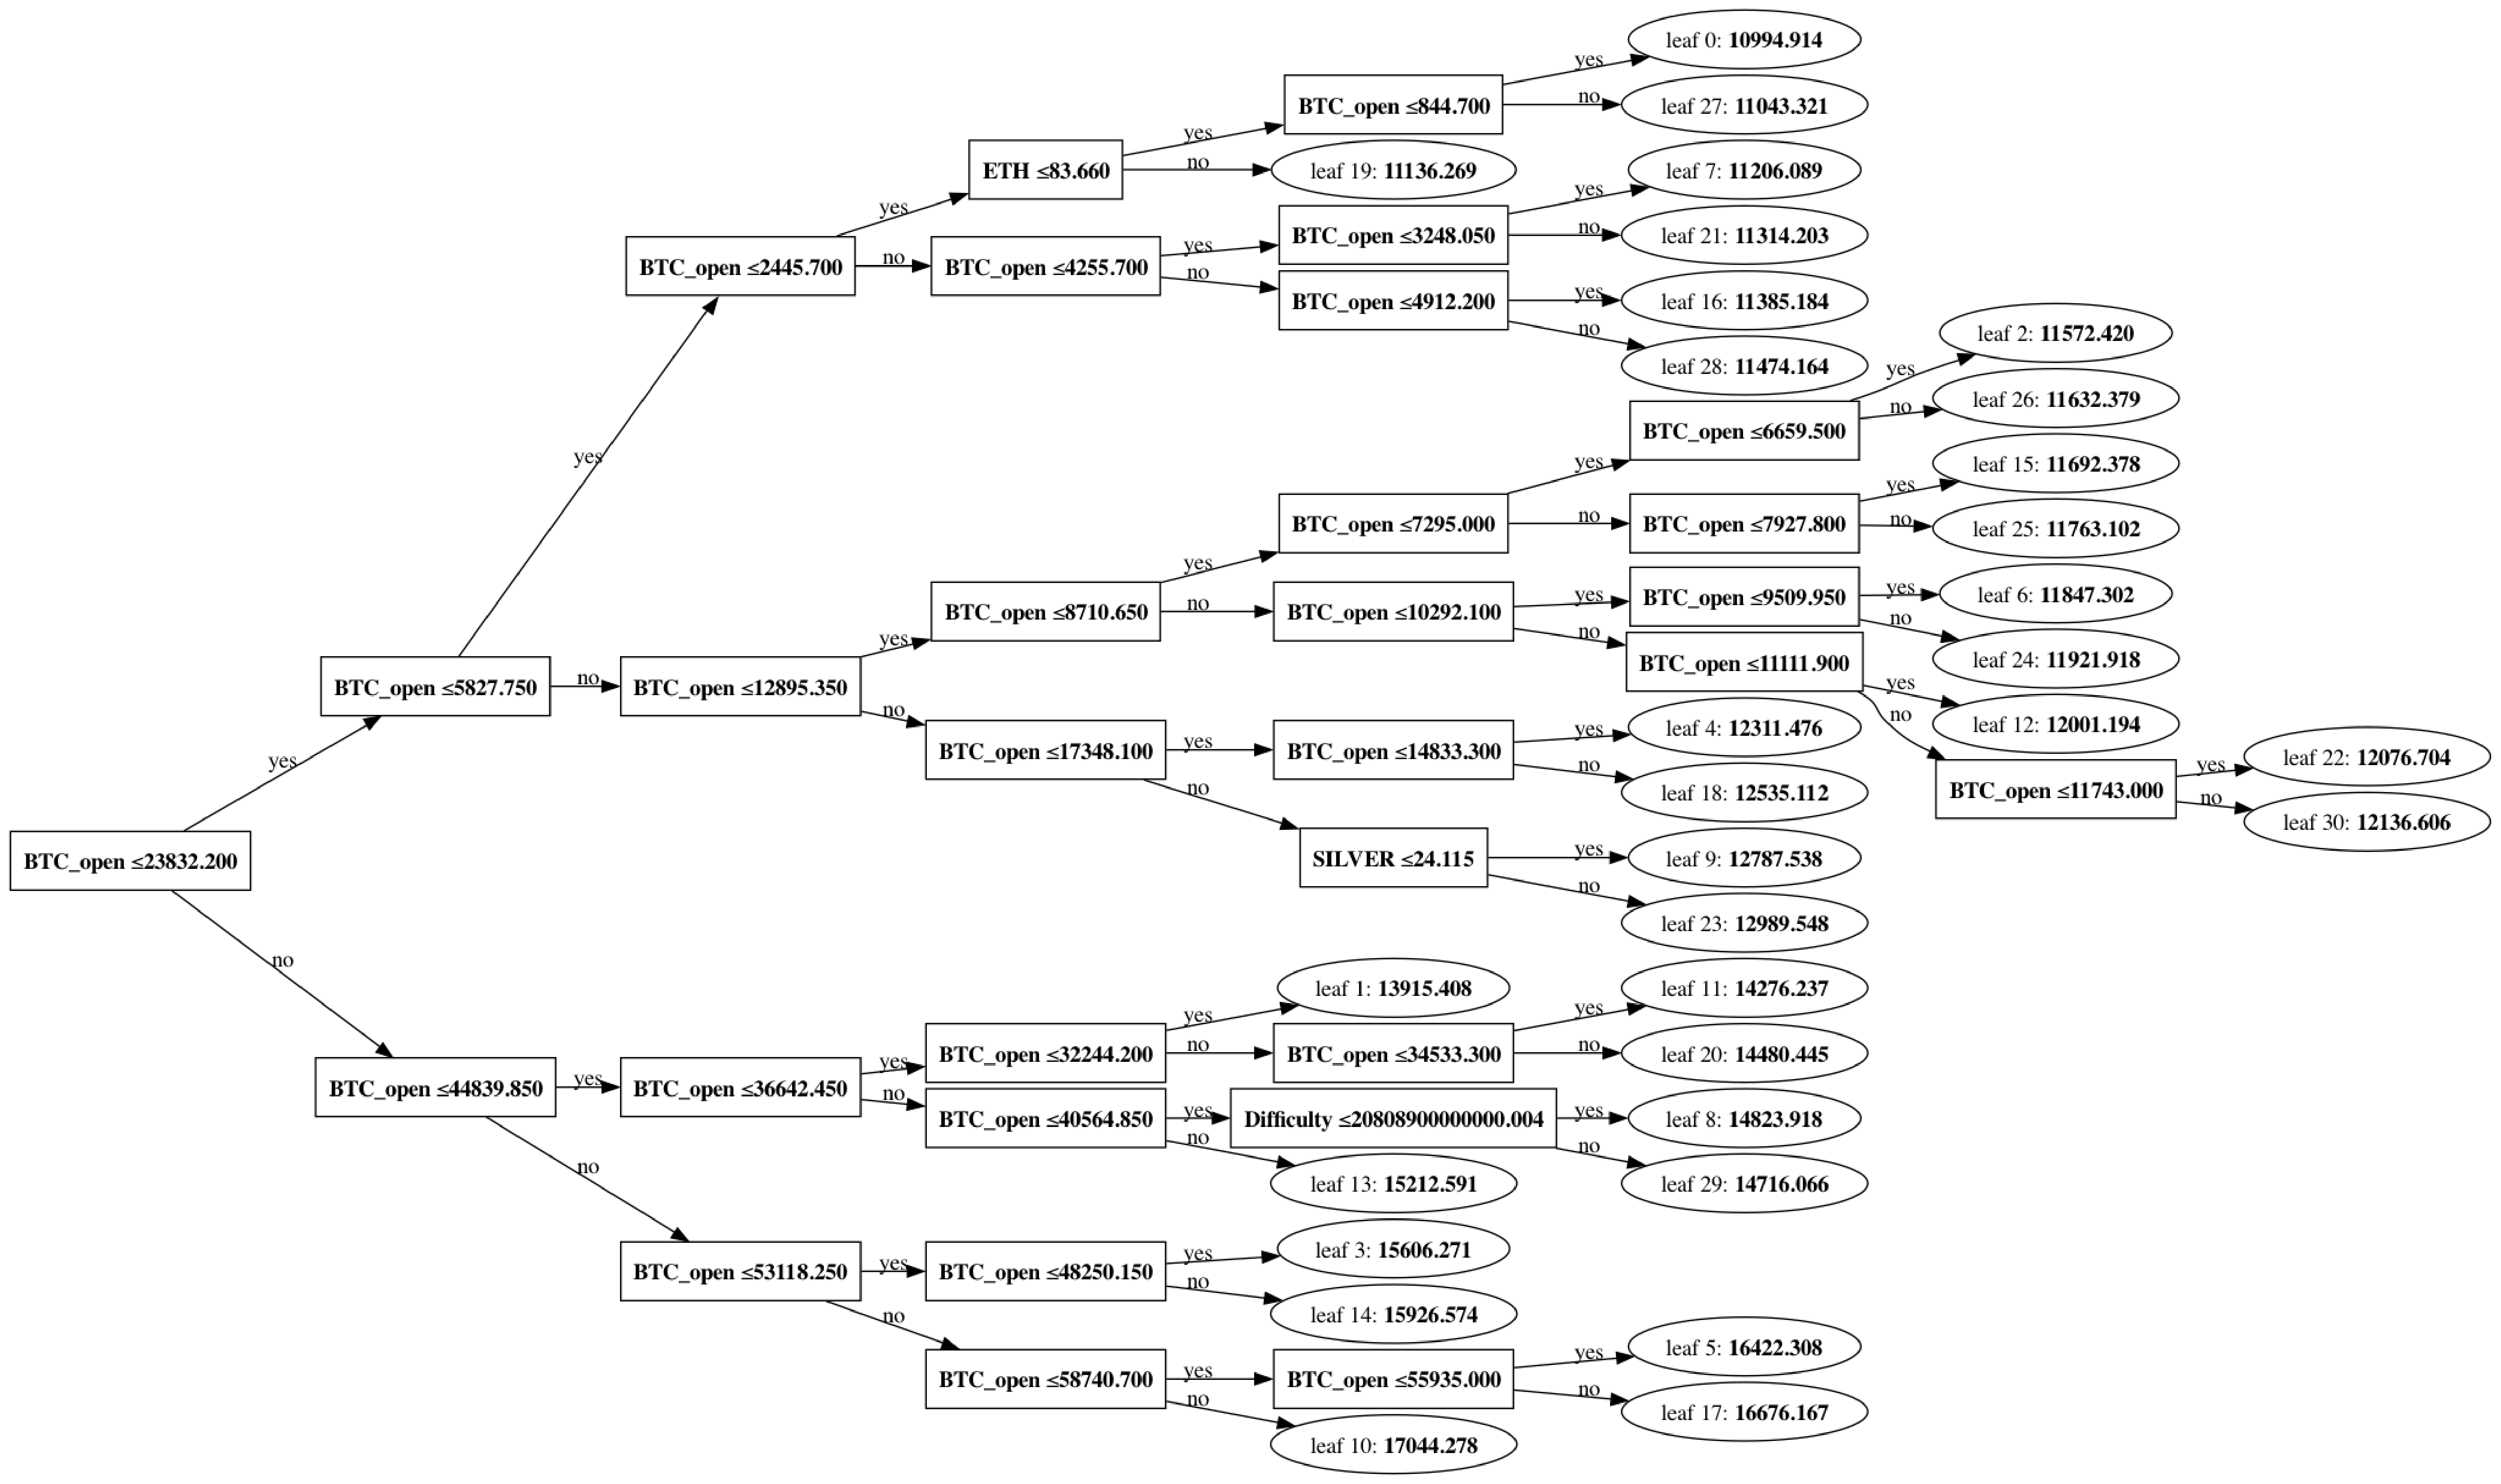

In [94]:
lgb.plot_tree(model, tree_index = 0, figsize=(80,80))


In [95]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import numpy as np
train_pred = model.predict(X_train)

y_test = np.array(y_test)

def AUC(y_test, y_pred):
    count = 0
    for i in range(1,len(y_test)):
        if (y_test[i] - y_test[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            count += 1
    return count/(len(y_test)-1)
print("Test accuracy for train set")
#RMSE
print("Root Mean Square Error (RMSE):", np.sqrt(mean_squared_error(y_train, train_pred)))

#MAPE
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_train,train_pred))
print()

print("Test accuracy for test set")
#RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Square Error (RMSE):", rmse)

#MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(" Mean Absolute Percentage Error (MAPE):", mape)
print()
AUC = AUC(y_test, predictions)
#AUC
print("AUC test:", AUC)

Test accuracy for train set
Root Mean Square Error (RMSE): 118.66790307072432
Mean Absolute Percentage Error (MAPE): 0.003764567091786967

Test accuracy for test set
Root Mean Square Error (RMSE): 1045.6918913200477
 Mean Absolute Percentage Error (MAPE): 0.03179816607915284

AUC test: 0.7037735849056603


### Tuning


##### For Better Accuracy
- Use large max_bin (may be slower)
- Use small learning_rate with large num_iterations
- Use large num_leaves (may cause over-fitting)
- Use bigger training data
- Try dart

In [96]:


SEARCH_PARAMS = {
    'learning_rate': [round(x, 2) for x in np.linspace(0.01, 0.1, num=10)],
    'max_depth': [int(x) for x in np.linspace(2, 10, num = 5)],
    'num_leaves': [int(x) for x in np.linspace(10, 35, num = 8)],
    'subsample': [0.8, 0.9, 1.0],
}

FIXED_PARAMS = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_bin': [500],
    'boosting_type': ['dart'],
    'random_state' : [42],
    'early_stopping_rounds': [10]
}
print(SEARCH_PARAMS)

{'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 'max_depth': [2, 4, 6, 8, 10], 'num_leaves': [10, 13, 17, 20, 24, 27, 31, 35], 'subsample': [0.8, 0.9, 1.0]}


In [97]:
# Kết hợp các tham số tìm kiếm và các tham số cố định thành một dict
param_distributions = {**SEARCH_PARAMS, **FIXED_PARAMS}

In [98]:
# Sử dụng RandomizedSearchCV để tìm kiếm siêu tham số tốt nhất
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5,  random_state = 42)
random_search.fit(X_train, y_train)


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')
/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['dart'],
                                        'early_stopping_rounds': [10],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                          0.07, 0.08, 0.09,
                                                          0.1],
                                        'max_bin': [500],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'metric': ['rmse'],
                                        'num_leaves': [10, 13, 17, 20, 24, 27,
                                                       31, 35],
                                        'objective': ['regression'],
                                        'random_state': [42],
                                        'subsample': [0.8, 0.9, 1.0]},
                   random_state=42)

In [99]:
# In ra bộ siêu tham số tốt nhất và kết quả tương ứng
print("Best Parameters: ", random_search.best_params_)


Best Parameters:  {'subsample': 0.8, 'random_state': 42, 'objective': 'regression', 'num_leaves': 24, 'metric': 'rmse', 'max_depth': 8, 'max_bin': 500, 'learning_rate': 0.09, 'early_stopping_rounds': 10, 'boosting_type': 'dart'}


In [100]:
# Đào tạo mô hình với bộ siêu tham số tốt nhất
best_model = lgb.LGBMRegressor(**random_search.best_params_)
best_model.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


LGBMRegressor(boosting_type='dart', early_stopping_rounds=10,
              learning_rate=0.09, max_bin=500, max_depth=8, metric='rmse',
              num_leaves=24, objective='regression', random_state=42,
              subsample=0.8)

In [101]:
# Đánh giá mô hình trên tập kiểm tra
y_pred = best_model.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print("Test Score:", score)

Test Score: 3997.8225493484106


In [102]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import numpy as np
y_train_pred = best_model.predict(X_train)

y_test = np.array(y_test)

def AUC(y_test, y_pred):
    count = 0
    for i in range(1,len(y_test)):
        if (y_test[i] - y_test[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            count += 1
    return count/(len(y_test)-1)
print("Test accuracy for train set")
#RMSE
print("Root Mean Square Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))

#MAPE
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_train,y_train_pred))
print()

print("Test accuracy for test set")
#RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error (RMSE):", rmse_lgb)

#MAPE
mape_lgb = mean_absolute_percentage_error(y_test, y_pred)
print(" Mean Absolute Percentage Error (MAPE):", mape_lgb)
print()
AUC_lgb = AUC(y_test, y_pred)
#AUC
print("AUC test:", AUC_lgb)

Test accuracy for train set
Root Mean Square Error (RMSE): 2000.519494490842
Mean Absolute Percentage Error (MAPE): 0.12278935918584466

Test accuracy for test set
Root Mean Square Error (RMSE): 3997.8225493484106
 Mean Absolute Percentage Error (MAPE): 0.09128050193039229

AUC test: 0.5509433962264151


## Feature Importance

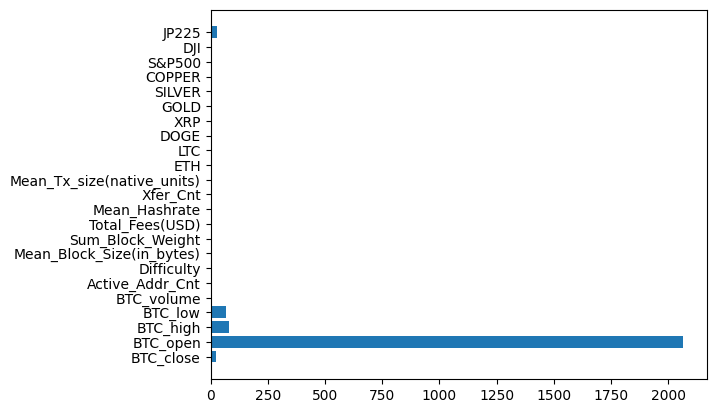

In [103]:
features = X_train.columns
importance_values = best_model.feature_importances_

plt.barh(y=range(len(features)), width=importance_values, tick_label=features)
plt.show()

## Normalization

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize the features using MinMaxScaler for the training dataset
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Normalize the features using the same scaler for the testing dataset
X_test_normalized = scaler.transform(X_test)

In [105]:
import time

start_time = time.time()

best_model.fit(X_train_normalized, y_train)

y_pred_norma = best_model.predict(X_test_normalized)

end_time = time.time()
normal_run_time = end_time - start_time

from sklearn.metrics import mean_squared_error

#RMSE
from sklearn.metrics import mean_squared_error
rmse_normal = np.sqrt(mean_squared_error(y_test, y_pred_norma))
print("RMSE:", rmse_normal)
print()

#MAPE
mape_normal = np.average(np.abs((y_test - y_pred_norma) / y_test))
print("MAPE:", mape_normal)
print()

AUC_normal = AUC(np.array(y_test), y_pred_norma)
print("AUC test:", AUC_normal )

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


RMSE: 3988.116277236592

MAPE: 0.09088871467856824

AUC test: 0.5433962264150943


# Graph Predicted Values with Test Set


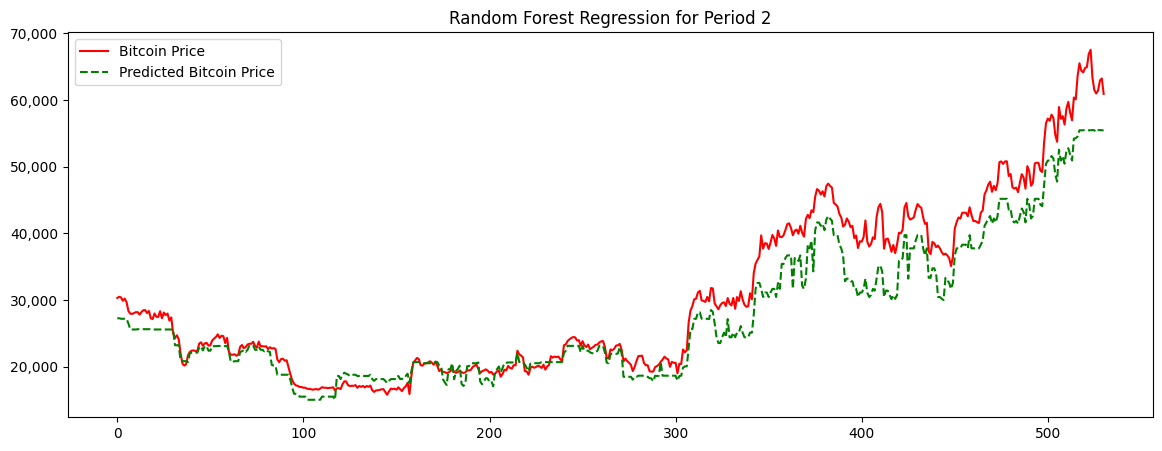

In [106]:

#hien thi ket qua du doan
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(y_test, color = 'red', label="Bitcoin Price")
ax.plot(y_pred, color = 'green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))  # .3f
plt.title("Random Forest Regression for Period 2")
plt.legend()
plt.show()

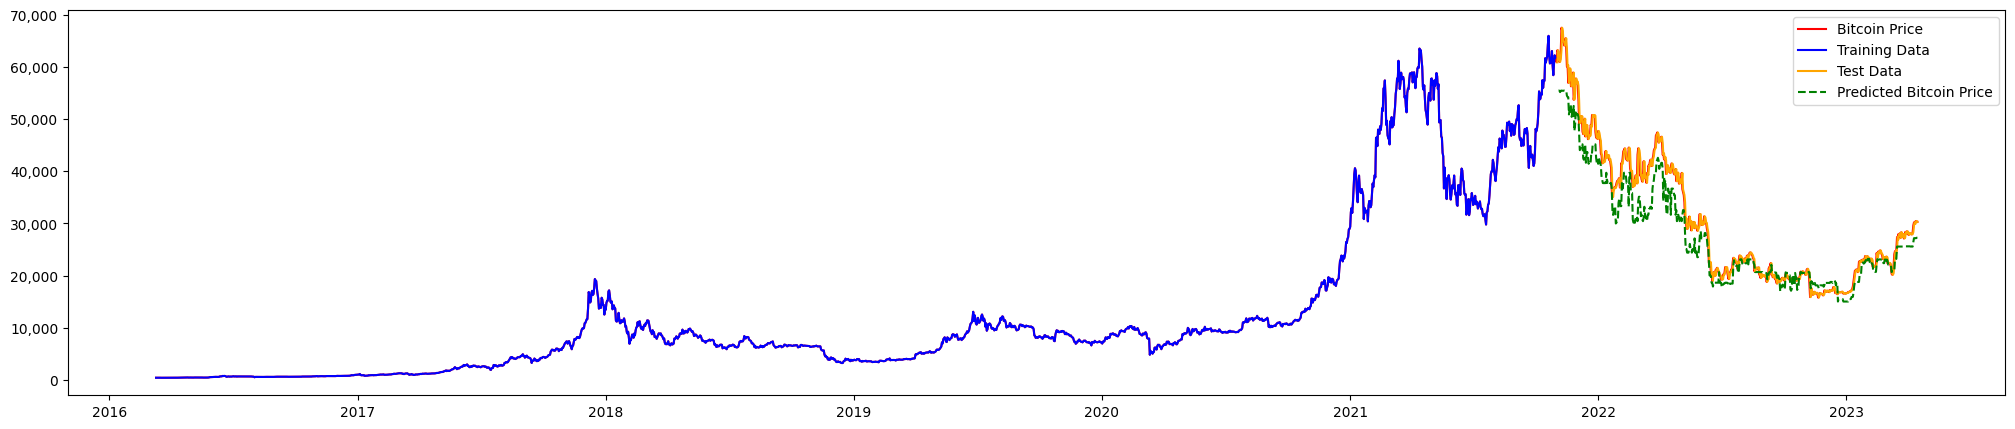

In [107]:
fig, ax = plt.subplots(figsize=(25, 5))

ax.plot(total['Date'], total['BTC_close'], color='red', label="Bitcoin Price")
ax.plot(total['Date'][-len(y_train):], y_train, color='blue', label="Training Data")
ax.plot(total['Date'][:len(y_test)], y_test, color='orange', label="Test Data")
ax.plot(total['Date'][:len(y_pred)], y_pred, color='green', label="Predicted Bitcoin Price", linestyle="dashed")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Định dạng đường trục y
plt.legend()
plt.show()


In [108]:
#the parameters used in the LGBMRegressor model
print(model.get_params())


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [109]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_accuracy(model, X_train, y_train, X_test, y_test):
    # Regression model
    model.fit(X_train, y_train)
    y_pred_regression_train = model.predict(X_train)
    y_pred_regression_test = model.predict(X_test)
    
    # Classification model
    classification_model = LGBMClassifier()
    classification_model.fit(X_train, y_train > 0)  # Phân loại thành nhóm "tăng" và "giảm"
    y_pred_classification_train = classification_model.predict(X_train)
    y_pred_classification_test = classification_model.predict(X_test)

    # Compare predictions and calculate accuracy for test set
    num_correct = 0
    num_total = len(y_test)

    for i in range(len(y_test)):
        if y_pred_classification_test[i] == 1:  # Dự đoán nhãn "tăng"
            if y_pred_regression_test[i] > y_test[i]:  # Dự đoán giá tăng
                num_correct += 1
        else:  # Dự đoán nhãn "giảm"
            if y_pred_regression_test[i] < y_test[i]:  # Dự đoán giá giảm
                num_correct += 1

    accuracy_test = num_correct / num_total
    
    # Compare predictions and calculate accuracy for train set
    num_correct = 0
    num_total = len(y_train)

    for i in range(len(y_train)):
        if y_pred_classification_train[i] == 1:  # Dự đoán nhãn "tăng"
            if y_pred_regression_train[i] > y_train[i]:  # Dự đoán giá tăng
                num_correct += 1
        else:  # Dự đoán nhãn "giảm"
            if y_pred_regression_train[i] < y_train[i]:  # Dự đoán giá giảm
                num_correct += 1

    accuracy_train = num_correct / num_total
    
    # Calculate RMSE for regression
    rmse_regression_train = mean_squared_error(y_train, y_pred_regression_train, squared=False)
    rmse_regression_test = mean_squared_error(y_test, y_pred_regression_test, squared=False)
    
    # Calculate MAPE for regression
    mape_regression_train = mean_absolute_percentage_error(y_train, y_pred_regression_train)
    mape_regression_test = mean_absolute_percentage_error(y_test, y_pred_regression_test)
    
    # Calculate for classification
    precision = precision_score(y_test > 0, y_pred_classification_test)
    recall = recall_score(y_test > 0, y_pred_classification_test)
    f1 = f1_score(y_test > 0, y_pred_classification_test)
    
    return accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, precision, recall, f1


In [110]:
accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, precision, recall, f1 = calculate_accuracy(best_model, X_train, y_train, X_test, y_test)

print("Accuracy - Train:", accuracy_train)
print("Accuracy - Test:", accuracy_test)

print("Regression Model - Train:")
print("RMSE:", rmse_regression_train)
print("MAPE:", mape_regression_train)

print("Regression Model - Test:")
print("RMSE:", rmse_regression_test)
print("MAPE:", mape_regression_test)

print("Classification Model:")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10


/usr/local/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


Accuracy - Train: 0.220281416787967
Accuracy - Test: 0.1751412429378531
Regression Model - Train:
RMSE: 2000.519494490842
MAPE: 0.12278935918584466
Regression Model - Test:
RMSE: 3997.8225493484106
MAPE: 0.09128050193039229
Classification Model:
Precision: 1.0
Recall: 1.0
F1: 1.0


In [111]:
accuracy_train, accuracy_test, rmse_regression_train, rmse_regression_test, mape_regression_train, mape_regression_test, precision, recall, f1 = calculate_accuracy(model, X_train, y_train, X_test, y_test)

print("Accuracy - Train:", accuracy_train)
print("Accuracy - Test:", accuracy_test)

print("Regression Model - Train:")
print("RMSE:", rmse_regression_train)
print("MAPE:", mape_regression_train)

print("Regression Model - Test:")
print("RMSE:", rmse_regression_test)
print("MAPE:", mape_regression_test)

print("Classification Model:")
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy - Train: 0.5254730713245997
Accuracy - Test: 0.5555555555555556
Regression Model - Train:
RMSE: 118.66790307072432
MAPE: 0.003764567091786967
Regression Model - Test:
RMSE: 1045.6918913200477
MAPE: 0.03179816607915284
Classification Model:
Precision: 1.0
Recall: 1.0
F1: 1.0


# Summary

| Metric     | DEFAULT | TUNING | NORMAL |
| ---------- | ------- | ------ | ------ |
| RMSE(min)  | 1045.69 | 537.751| 2420.24|
| MAPE%(min) | 0.03    | 0.06   | 0.06   |
| AUC/DA ~ 1 | 0.70    | 0.67   | 0.65   |
